In [65]:
# Very few imports. This is a pure torch solution!
import random
import os
import copy
import cv2
import time
import shutil
from collections import defaultdict
from tqdm import tqdm
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
import torchvision.models as models
cudnn.benchmark = True

# Constants

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BASE_DIR = "../data/train_images/"

# NUM_EPOCHS = 12
NUM_EPOCHS = 1

# Load `df`

### See: [🐠 Reef - CV strategy: subsequences!](https://www.kaggle.com/julian3833/reef-cv-strategy-subsequences)

In [4]:
df = pd.read_csv("../data/train-0.1.csv")

# Turn annotations from strings into lists of dictionaries
df['annotations'] = df['annotations'].apply(eval)

# Create the image path for the row
df['image_path'] = "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,n_annotations,has_annotations,image_path,subsequence_id,is_train
0,0,40258,0,0,0-0,[],0,False,video_0/0.jpg,1,True
1,0,40258,1,1,0-1,[],0,False,video_0/1.jpg,1,True
2,0,40258,2,2,0-2,[],0,False,video_0/2.jpg,1,True
3,0,40258,3,3,0-3,[],0,False,video_0/3.jpg,1,True
4,0,40258,4,4,0-4,[],0,False,video_0/4.jpg,1,True


In [5]:
df_train, df_val = df[df['is_train']], df[~df['is_train']]

In [6]:
# The model doesn't support images with no annotations
# It raises an error that suggest that it just doesn't support them:
# V    alueError: No ground-truth boxes available for one of the images during training
# I'm dropping those images for now
# https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/3
df_train = df_train[df_train.annotations.str.len() > 0 ].reset_index(drop=True)
df_val = df_val[df_val.annotations.str.len() > 0 ].reset_index(drop=True)
df_train.shape[0], df_val.shape[0]

(4396, 523)

## Dataset class

In [128]:
class ReefDataset:

    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def can_augment(self, boxes):
        """ Check if bounding boxes are OK to augment
        For example: image_id 1-490 has a bounding box that is partially outside of the image
        It breaks albumentation
        Here we check the margins are within the image to make sure the augmentation can be applied
        """
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image

    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(float).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return boxes
    
    def get_image(self, row):
        """Gets the image for a given row"""
        
        image = cv2.imread(f'{BASE_DIR}/{row["image_path"]}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        image = self.get_image(row)
        boxes = self.get_boxes(row)
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            'image_id': torch.tensor([i]),
            # There is only one class
            'labels': torch.ones((n_boxes,), dtype=torch.int64),
            # Suppose all instances are not crowd
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64)            
        }

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if n_boxes > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            image = ToTensorV2(p=1.0)(image=image)['image']

        return image, target

    def __len__(self):
        return len(self.df)

## Augmentations

In [118]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transforms = A.Compose([t for t in dataset.transforms if not isinstance(t, (A.Normalize, ToTensorV2))], 
                                   bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area':256,  'min_visibility':0.6})
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [131]:
def recover_clahe(sceneRadiance):
    clahe = cv2.createCLAHE(clipLimit=7, tileGridSize=(14, 14))
    for i in range(3):
        sceneRadiance[:, :, i] = clahe.apply((sceneRadiance[:, :, i]*255).astype(np.uint8)).astype(np.float32) / 255.0
    return sceneRadiance

class RecoverCLAHE(ImageOnlyTransform):
    def apply(self, img, **params):
        return recover_clahe(img)

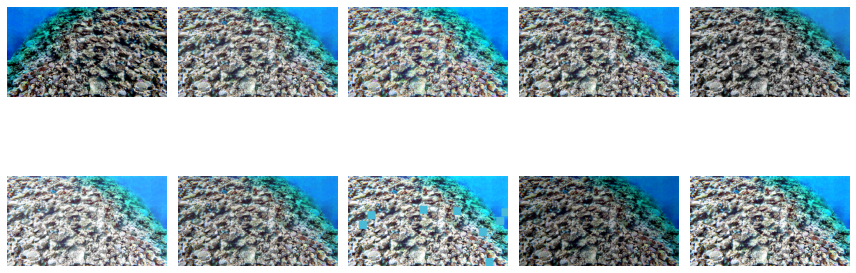

In [149]:
# exp3
def get_train_transform():
    return A.Compose([
        RecoverCLAHE(p=1.0),
        A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=(0.21, 0.58, 0.68), p=0.2),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.4, sat_shift_limit=0.4, val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
        ], p=0.9),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(p=1.0) # HWC -> CHW
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area':256,  'min_visibility':0.6})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area':256,  'min_visibility':0.6})

A.Compose([
    RecoverCLAHE(p=1.0),
    A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=(0.21, 0.58, 0.68), p=0.2),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=0.4, sat_shift_limit=0.4, val_shift_limit=0.2, p=0.9),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
    ], p=0.9),
    A.Ad
    A.HorizontalFlip(p=0.5),
    ToTensorV2(p=1.0) # HWC -> CHW
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area':256,  'min_visibility':0.6})

# Define datasets
ds_train = ReefDataset(df_train, transforms=get_train_transform())
ds_val = ReefDataset(df_val, transforms=get_valid_transform())

visualize_augmentations(ds_train, idx=1)